In [1]:
import numpy as np
from numpy import random
from tqdm import tqdm
from autograd import grad 
import matplotlib.pyplot as plt
import scipy.stats as stats

dt values: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]


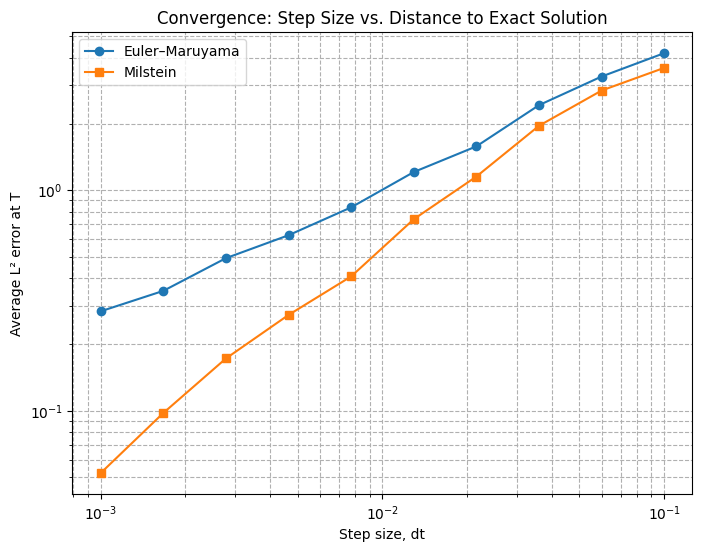

In [36]:
a = 2      # drift coefficient
b = 1      # diffusion coefficient
T = 1.0       # final time
x0 = 1.0      # initial condition

num_trajectories = 1000
num_simulations  = 100  

def generate_noise(dt, T, num_trajectories):
    num_steps = int(T / dt) + 1
    dW = np.sqrt(dt) * np.random.randn(num_steps - 1, num_trajectories)
    W = np.zeros((num_steps, num_trajectories))
    W[1:] = np.cumsum(dW, axis=0)
    return W

def euler_maruyama(dt, T, x0, noise):
    num_steps = noise.shape[0]
    x = np.zeros((num_steps, noise.shape[1]))
    x[0] = x0
    for i in range(num_steps - 1):
        dW = noise[i+1] - noise[i]
        x[i+1] = x[i] + a * x[i] * dt + b * x[i] * dW
    return x

def milstein(dt, T, x0, noise):
    num_steps = noise.shape[0]
    x = np.zeros((num_steps, noise.shape[1]))
    x[0] = x0
    for i in range(num_steps - 1):
        dW = noise[i+1] - noise[i]
        x[i+1] = x[i] + a * x[i] * dt + b * x[i] * dW \
                 + 0.5 * (b**2) * x[i] * (dW**2 - dt)
    return x

def exact_solution(T, x0, noise):
    return x0 * np.exp((a - 0.5 * b**2) * T + b * noise[-1])

def compute_rmse(numerical, exact):
    return np.sqrt(np.mean((numerical - exact)**2))

dt_values = np.logspace(-3, -1, num=10)

errors_euler   = []
errors_milstein = []

for dt in tqdm(dt_values, desc="dt values"):
    euler_errors   = []
    milstein_errors = []
    
    for _ in range(num_simulations):
        noise = generate_noise(dt, T, num_trajectories)
        
        x_euler   = euler_maruyama(dt, T, x0, noise)
        x_milstein = milstein(dt, T, x0, noise)
        
        x_exact = exact_solution(T, x0, noise)
        
        err_euler   = compute_rmse(x_euler[-1], x_exact)
        err_milstein = compute_rmse(x_milstein[-1], x_exact)
        
        euler_errors.append(err_euler)
        milstein_errors.append(err_milstein)
    
    errors_euler.append(np.mean(euler_errors))
    errors_milstein.append(np.mean(milstein_errors))


plt.figure(figsize=(8, 6))
plt.loglog(dt_values, errors_euler, 'o-', label='Euler–Maruyama')
plt.loglog(dt_values, errors_milstein, 's-', label='Milstein')
plt.xlabel('Step size, dt')
plt.ylabel('Average L² error at T')
plt.title('Convergence: Step Size vs. Distance to Exact Solution')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


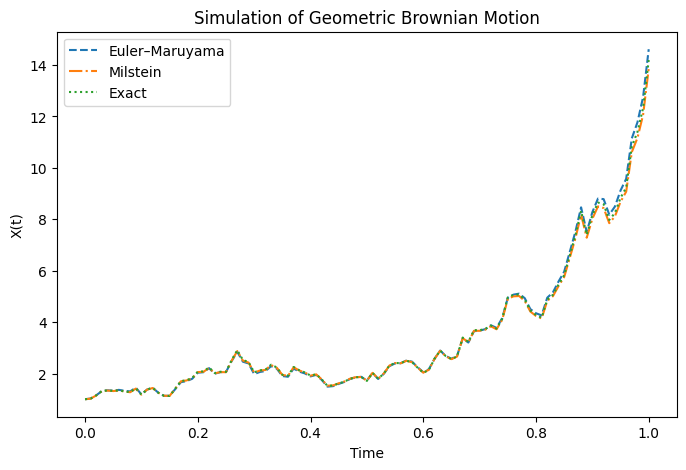

In [ ]:
num_trajectories = 1
num_steps = int(T / dt) + 1  # Number of time steps
time = np.linspace(0, T, num_steps)

dW = np.sqrt(dt) * np.random.randn(num_steps - 1, num_trajectories) 
W = np.zeros((num_steps, num_trajectories))
W[1:] = np.cumsum(dW, axis=0)  

Y = x0 * np.exp((a - 0.5 * b**2) * time[:, None] + b * W)

dt = 0.01
x_euler = euler_maruyama(dt, T, x0, W)[:, 0]  
x_milstein = milstein(dt, T, x0, W)[:, 0]
x_exact = Y[:, 0] 

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(time, x_euler, label='Euler–Maruyama', linestyle='--')
plt.plot(time, x_milstein, label='Milstein', linestyle='-.')
plt.plot(time, x_exact, label='Exact', linestyle=':')
plt.xlabel('Time')
plt.ylabel('X(t)')
plt.title('Simulation of Geometric Brownian Motion')
plt.legend()
plt.show()

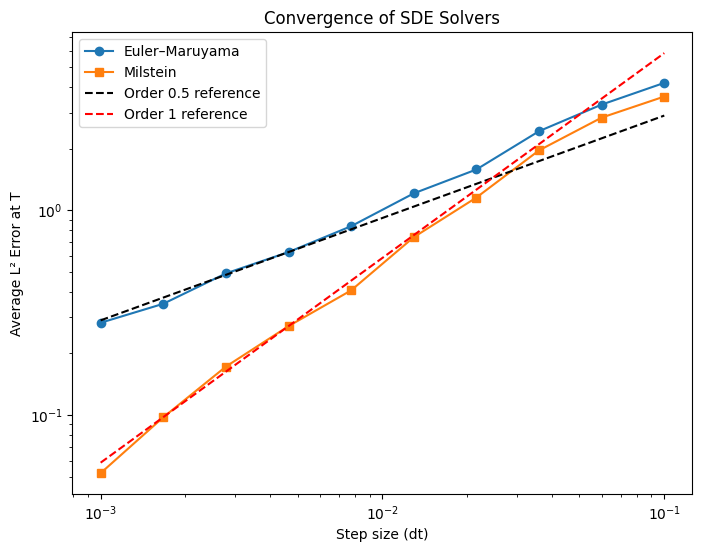

In [37]:
log_dt = np.log(dt_values)
log_err_euler = np.log(errors_euler)
log_err_milstein = np.log(errors_milstein)

slope_euler, intercept_euler = np.polyfit(log_dt, log_err_euler, 1)
slope_milstein, intercept_milstein = np.polyfit(log_dt, log_err_milstein, 1)

plt.figure(figsize=(8, 6))
plt.loglog(dt_values, errors_euler, 'o-', label='Euler–Maruyama')
plt.loglog(dt_values, errors_milstein, 's-', label='Milstein')
plt.xlabel('Step size (dt)')
plt.ylabel('Average L² Error at T')
plt.title('Convergence of SDE Solvers')

# reference step size
ref_dt = dt_values[3]
# reference error
ref_err_euler = errors_euler[3]
# We expect error = O(dt^(0.5)), i.e. error = C dt^(0.5) so C = error/dt^(0.5). Thus, at ref_dt, C=ref_err/ref_dt^(0.5). 
# And error would be Error = ref_err * (dt/ref_dt)^(0.5)  
dt_line = np.array([min(dt_values), max(dt_values)])
ref_line_euler = ref_err_euler * (dt_line / ref_dt)**0.5
plt.loglog(dt_line, ref_line_euler, 'k--', label='Order 0.5 reference')

#reference_error_EM = [np.sqrt(dt_value) for dt_value in dt_line]
#reference_error_M = [dt_value for dt_value in dt_line]

# Similarly for Milstein (order 1)
ref_err_milstein = errors_milstein[3]
ref_line_milstein = ref_err_milstein * (dt_line / ref_dt)**1.0
plt.loglog(dt_line, ref_line_milstein, 'r--', label='Order 1 reference')

plt.legend()
#plt.grid(True, which="both", ls="--")
plt.show()


dt values: 100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


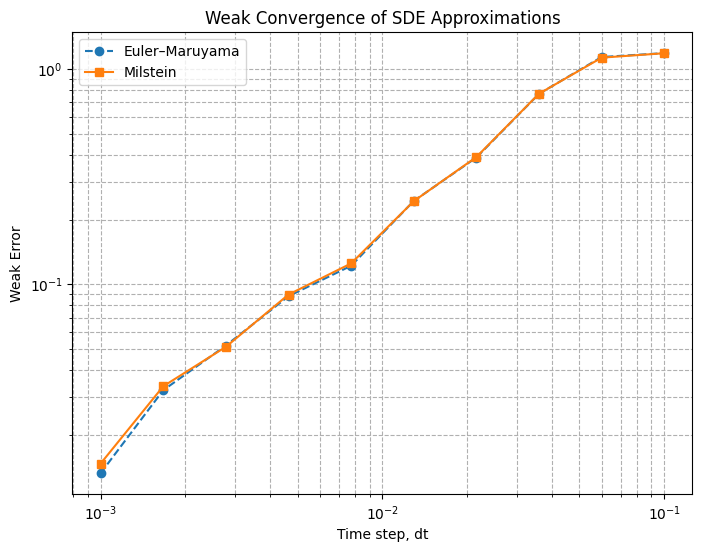

Estimated convergence order for Euler–Maruyama: 0.9943215742469907
Estimated convergence order for Milstein: 0.9793775155499909


In [6]:
weak_err_em = []
weak_err_mil = []

for dt in tqdm(dt_values, desc="dt values"):
    sim_expect_em = []
    sim_expect_mil = []
    sim_expect_exact = []
    
    for _ in range(num_simulations):
        noise = generate_noise(dt, T, num_trajectories)
        x_euler   = euler_maruyama(dt, T, x0, noise)
        x_milstein = milstein(dt, T, x0, noise)
        x_exact = exact_solution(T, x0, noise)
        
        sim_expect_em.append(x_euler[-1])
        sim_expect_mil.append(x_milstein[-1])
        sim_expect_exact.append(x_exact)
    
    # Average the estimates over the simulation runs
    avg_em    = np.mean(sim_expect_em)
    avg_mil   = np.mean(sim_expect_mil)
    avg_exact = np.mean(sim_expect_exact)
    
    # Compute the weak error
    weak_err_em.append(compute_rmse(avg_em,avg_exact))
    weak_err_mil.append(compute_rmse(avg_mil,avg_exact))

# Plot on a log–log plot
plt.figure(figsize=(8,6))
plt.loglog(dt_values, weak_err_em, 'o--', label="Euler–Maruyama")
plt.loglog(dt_values, weak_err_mil, 's-', label="Milstein")
plt.title('Weak Convergence of SDE Approximations')
plt.xlabel('Time step, dt')
plt.ylabel('Weak Error')
plt.legend(loc=2)
plt.grid(True, which="both", ls="--")
plt.show()

log_dt = np.log(dt_values)
log_err_euler = np.log(weak_err_em)
log_err_milstein = np.log(weak_err_mil)

slope_euler, intercept_euler = np.polyfit(log_dt, log_err_euler, 1)
slope_milstein, intercept_milstein = np.polyfit(log_dt, log_err_milstein, 1)

print("Estimated convergence order for Euler–Maruyama:", slope_euler)
print("Estimated convergence order for Milstein:", slope_milstein)